In [148]:
# reference of sample implementation of positional encoding: https://www.tensorflow.org/text/tutorials/transformer

import logging
import numpy as np
import matplotlib.pyplot as plt

In [128]:
def get_angles(pos, i, d_model, freq = 10000):
  angle_rates = 1 / np.power(freq, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [129]:
def positional_encoding(position, d_model, freq=10000):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model, freq=freq)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [130]:
def compareFrequency(n, d_model, freqs=[10000]):
  dists_by_freq = []
  for freq in freqs:
    pos_encoding = positional_encoding(n, d, freq)[0]
    dists = [[0] * n for i in np.arange(n)]
    for i in np.arange(n):
      for j in np.arange(n):
        if i >= j:
          dists[i][j] = np.sum(np.dot(pos_encoding[i,:], pos_encoding[j,:])) 
    for i in np.arange(n):
      for j in np.arange(n):
        if i < j:
          dists[i][j] = dists[j][i]
    dists_by_freq.append(dists[:4])
  return dists_by_freq
  

## Positional Encoding

The positional encoding in the transformer tries to encode the relationships among toekns at different positions (tokens are more affected by their closer neighors than those are farther away). The current implementations utilize the fact that sin/cos waves which are closer in the frequency space are closer to each other in the cosine distance space of embedding features. 

The contextual effects among tokens far away are pretty noisy and it's better to ignore those effects by setting the length of positional tokens not too large (e.g. making the effects within 1% of the maximum one, measured by 1-dist if the dist is normalized for instance).

Using the carrier modulation to integrate positional encoding, instead of encoding addition, can avoid the tuning of relative weights between original embeddings and the positional encoded embeddings (did not check if this has been implemented or not).

**Below**, we show how the different parameters of (n, d_model) affects the correctness of positional encoding. In a nutshell, frequency precision/step(proportional to 1/freq) needs to be small or freq here needs to be large to avoid periodic effect of sin/cos. That means, d_model needs to be large and n needs to be comparatively small to d_model to ensure the correctness and accuracy of position encoding (e.g. the tailing fluctuation in correlation is not too noisy).

In [144]:
def plotPositionalDistanceByFreq(n, d_model=None, freqs=None, valid_length=None, n_top_pos=None):
  n_freq = len(freqs)
  fig, axs = plt.subplots(n_freq, n_top_pos, figsize=[18, 25])
  for i in np.arange(n_freq):
    for j in np.arange(n_top_pos):
      freq_precision = np.power(freqs[i], 1 / np.float32(d))
      label=f'freq precision: {freq_precision}'
      axs[i][j].set_title(label)
      axs[i][j].plot(dists_by_freq[i][j][:valid_length]/np.max(dists_by_freq[i]), '.')

In [133]:
freqs = [1, 10, 100, 1000, 10000, 100000]

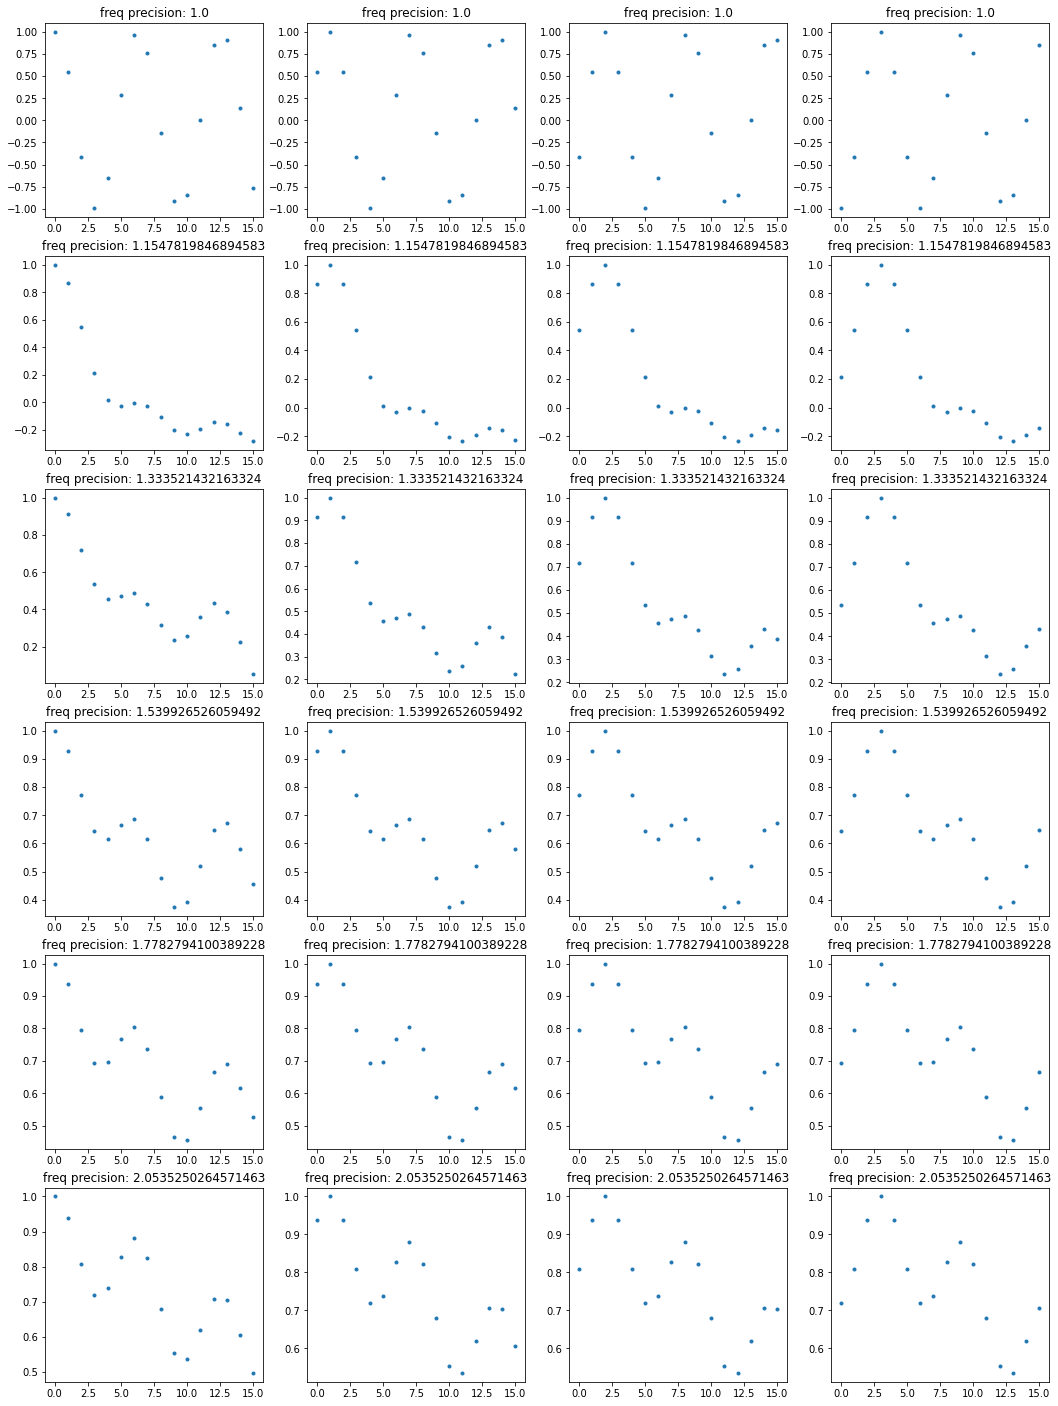

In [145]:
# if d is too small, the sequence does not approximate the sin/cos wave well, 
# which introduce inaccuracy in distance calculation between two sin/cos of different frequency.

n = 32
d = 16
dists_by_freq = compareFrequency(n, d, freqs)

n_freq = 5
n_top_pos = 4
valid_length = 16

plotPositionalDistanceByFreq(n, d_model=d, freqs=freqs, valid_length=valid_length, n_top_pos=n_top_pos)

In [ ]:
# if d is small compared to n, the assumed relational effects that closer 
# tokens affect each other more will be affected by the sin/cos periodic property, because the frequency precision/step gets too big.
# We can see that tokens farther can affect the token much more than the closer ones.

n = 2048
d = 512
dists_by_freq = compareFrequency(n, d, [1, 10, 100, 1000, 10000, 100000])

n_freq = 5
n_pos = 4
valid_pos = 16
fig, axs = plt.subplots(n_freq, n_pos, figsize=[18, 25])
for i in np.arange(n_freq):
  for j in np.arange(n_pos):
    axs[i][j].plot(dists_by_freq[i][j][:valid_pos]/np.max(dists_by_freq[i]), '.')

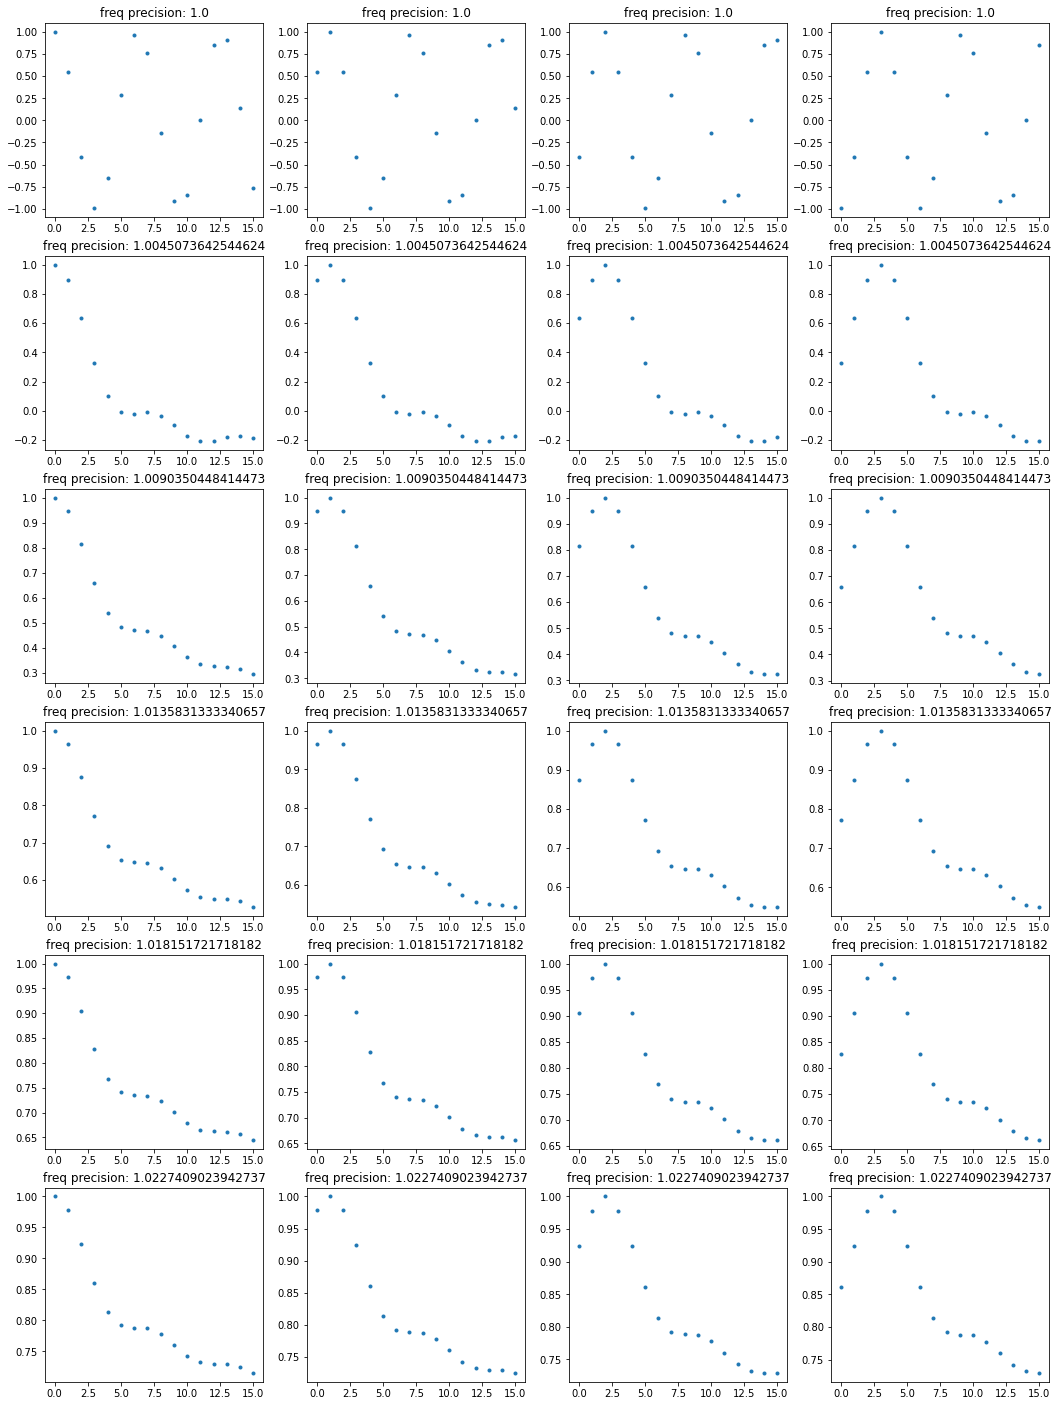

In [146]:
# Example of the correct parameter set.
n = 32
d = 512
dists_by_freq = compareFrequency(n, d, [1, 10, 100, 1000, 10000, 100000])

n_freq = 5
n_pos = 4
valid_pos = 16

plotPositionalDistanceByFreq(n, d_model=d, freqs=freqs, valid_length=valid_length, n_top_pos=n_top_pos)